In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import tensorflow as tf


In [3]:
BASE_PATH = r"c:\Users\acer\Downloads\archive\Rice_Image_Dataset"
OUTPUT_CSV = os.path.join(BASE_PATH, "Rice_df.csv")

In [4]:
def prepare_dataframe(base_link):
    classes = os.listdir(base_link)
    rice_class = classes[0:5]
    print("Classes found:", rice_class)

In [5]:
classes = [f for f in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, f))]
rice_classes = classes[:5]

In [6]:
image_paths = list(Path(BASE_PATH).rglob("*.jpg"))
image_names = [img.parent.stem for img in image_paths]
label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_names)


In [7]:
df = pd.DataFrame({
    "link": [str(p) for p in image_paths],
    "name": image_names,
    "label": encoded_labels
})

In [8]:
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ CSV saved to {OUTPUT_CSV}")

✅ CSV saved to c:\Users\acer\Downloads\archive\Rice_Image_Dataset\Rice_df.csv


In [9]:
df

,link,name,label
0,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Arborio,0
1,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Arborio,0
2,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Arborio,0
3,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Arborio,0
4,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Arborio,0
...,...,...,...
74995,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Karacadag,4
74996,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Karacadag,4
74997,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Karacadag,4
74998,c:\Users\acer\Downloads\archive\Rice_Image_Dat...,Karacadag,4


C:\Users\acer\AppData\Local\Temp\ipykernel_16116\3563512785.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="name", palette="Set2")


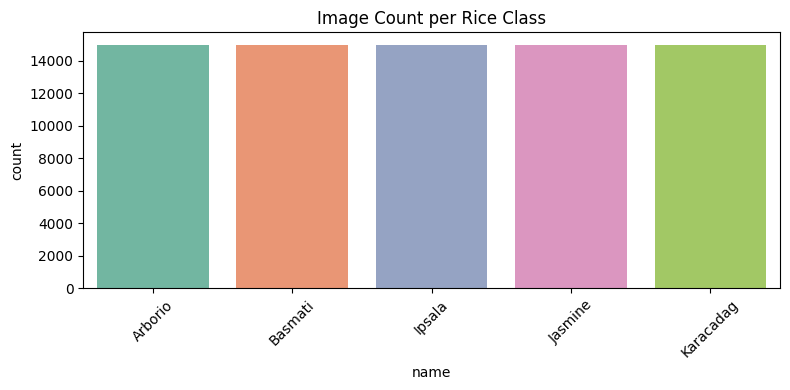

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="name", palette="Set2")
plt.xticks(rotation=45)
plt.title("Image Count per Rice Class")
plt.tight_layout()
plt.show()

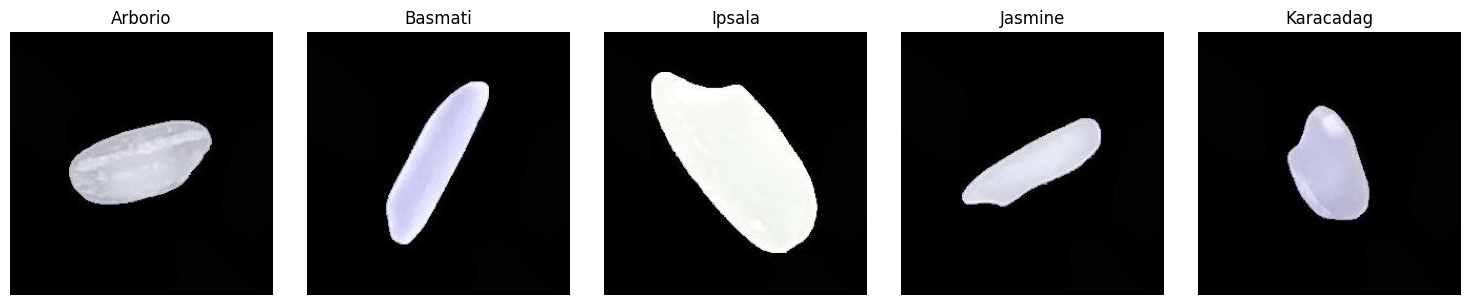

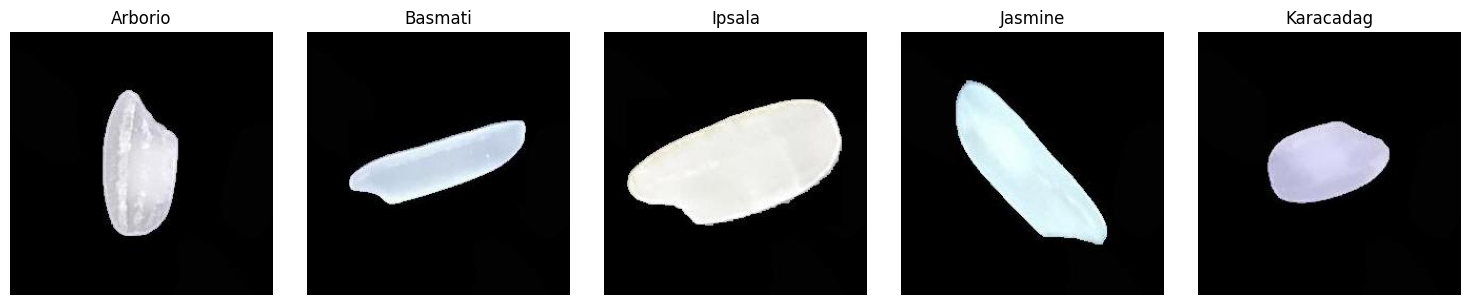

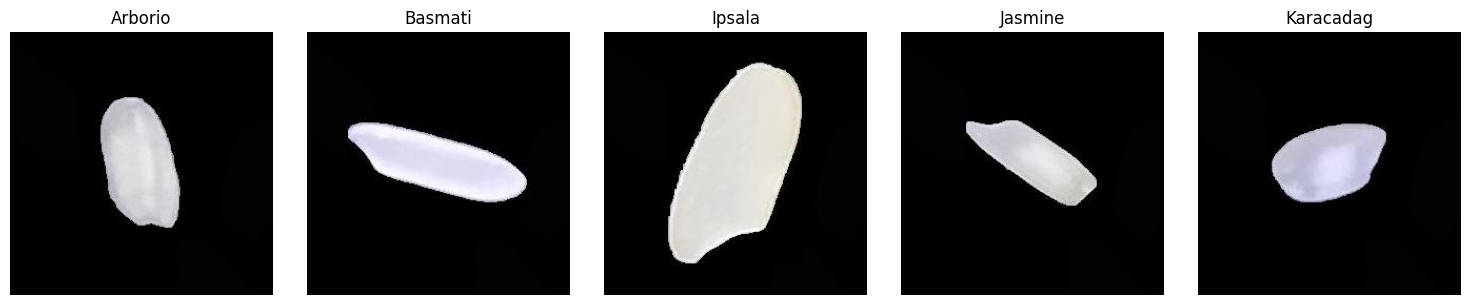

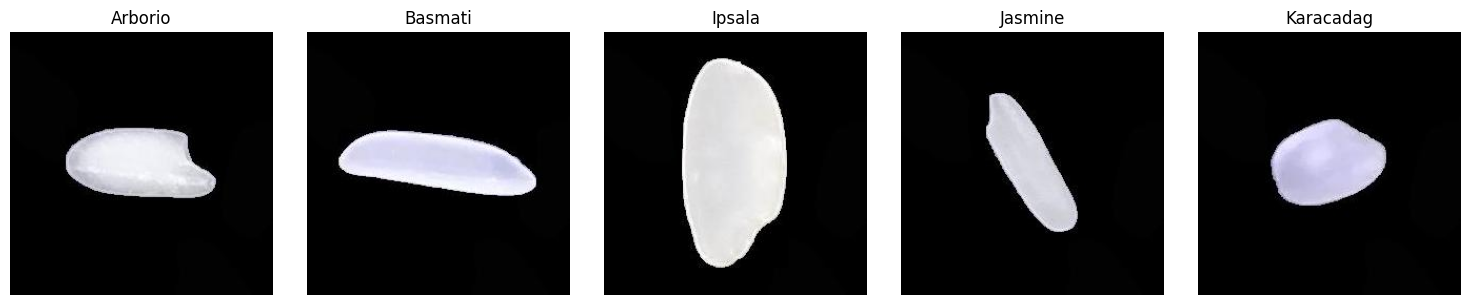

In [11]:
def show_sample_images(path, class_list, rounds=4):
    for _ in range(rounds):
        plt.figure(figsize=(15, 3))
        for i, cls in enumerate(class_list):
            folder = os.path.join(path, cls)
            images = [f for f in os.listdir(folder) if f.endswith(".jpg")]
            if images:
                file = np.random.choice(images)
                img = cv2.imread(os.path.join(folder, file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(1, len(class_list), i + 1)
                plt.imshow(img)
                plt.title(cls)
                plt.axis("off")
        plt.tight_layout()
        plt.show()

show_sample_images(BASE_PATH, rice_classes)

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
datagen = ImageDataGenerator()

train_gen = datagen.flow_from_dataframe(train_df, x_col="link", y_col="name", target_size=(100, 100), class_mode="categorical", seed=42)
val_gen   = datagen.flow_from_dataframe(test_df, x_col="link", y_col="name", target_size=(100, 100), class_mode="categorical", seed=42)


Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


In [13]:
model = Sequential([
    Conv2D(15, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(30, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(50, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation="relu"),
    Dropout(0.25),
    Dense(5, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 15)     │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 15)     │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 30)     │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15870)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,587,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,597,995 (6.10 MB)

 Trainable params: 1,597,605 (6.09 MB)

 Non-trainable params: 390 (1.52 KB)

In [27]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint("model_cnn.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.001, verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.7585 - loss: 0.6490
Epoch 1: val_accuracy improved from -inf to 0.98747, saving model to model_cnn.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1614s 861ms/step - accuracy: 0.7585 - loss: 0.6489 - val_accuracy: 0.9875 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9324 - loss: 0.1849
Epoch 2: val_accuracy did not improve from 0.98747
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 232s 124ms/step - accuracy: 0.9324 - loss: 0.1849 - val_accuracy: 0.9440 - val_loss: 0.2034 - learning_rate: 0.0010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9475 - loss: 0.1456
Epoch 3: val_accuracy improved from 0.98747 to 0.98960, saving model to model_cnn.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 235s 126ms/step - accuracy: 0.9475 - loss: 0.1456 - val_accuracy: 0.9896 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accura

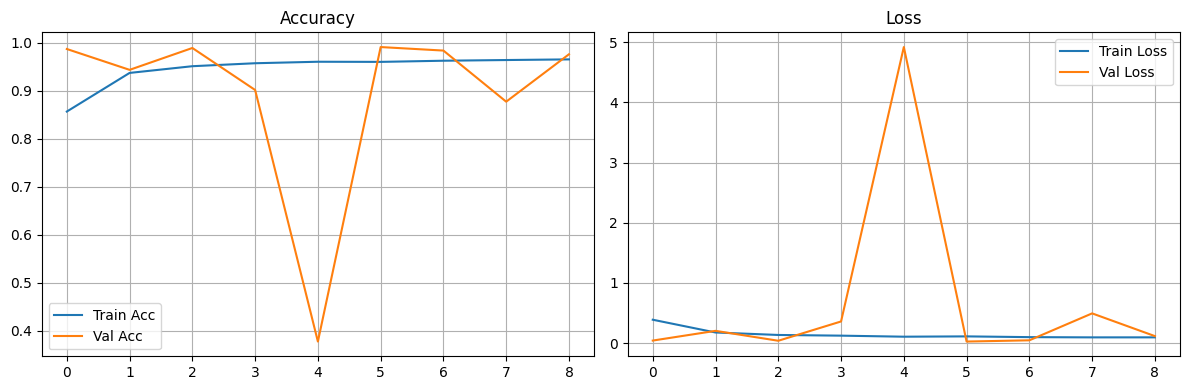

In [28]:
def plot_history(hist):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.grid(); plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend(); plt.grid(); plt.title("Loss")
    plt.tight_layout()
    plt.show()

plot_history(history)

469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step


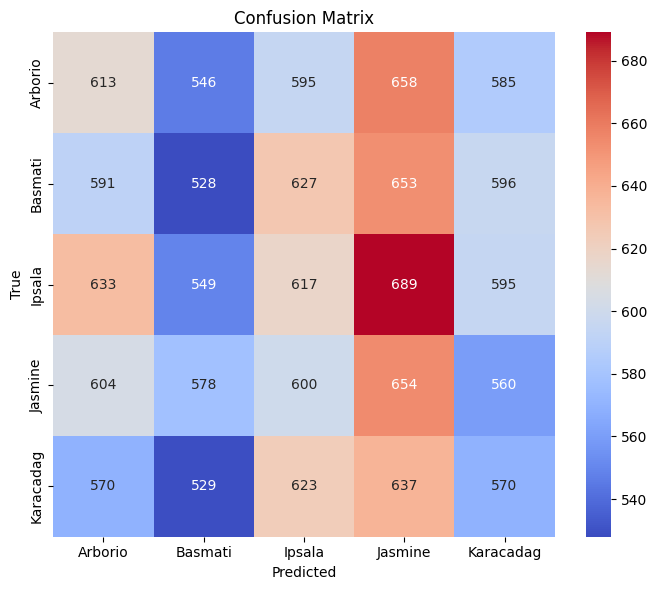

In [29]:
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
conf_matrix = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=list(train_gen.class_indices.keys()),
            yticklabels=list(train_gen.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


✅ CSV saved to c:\Users\acer\Downloads\archive\Rice_Image_Dataset\Rice_df.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_19464\928132011.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="name", palette="Set2")


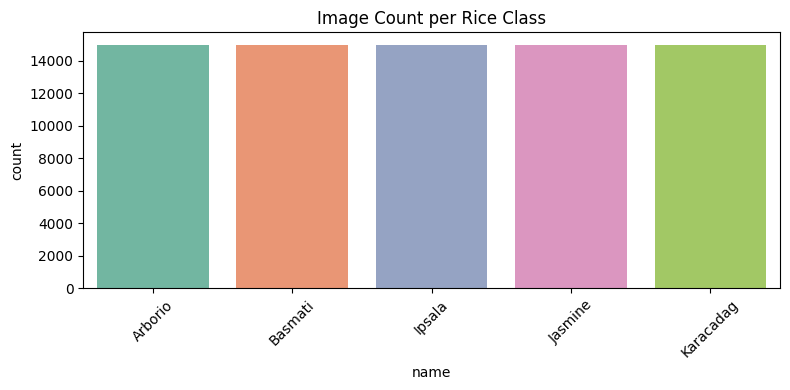

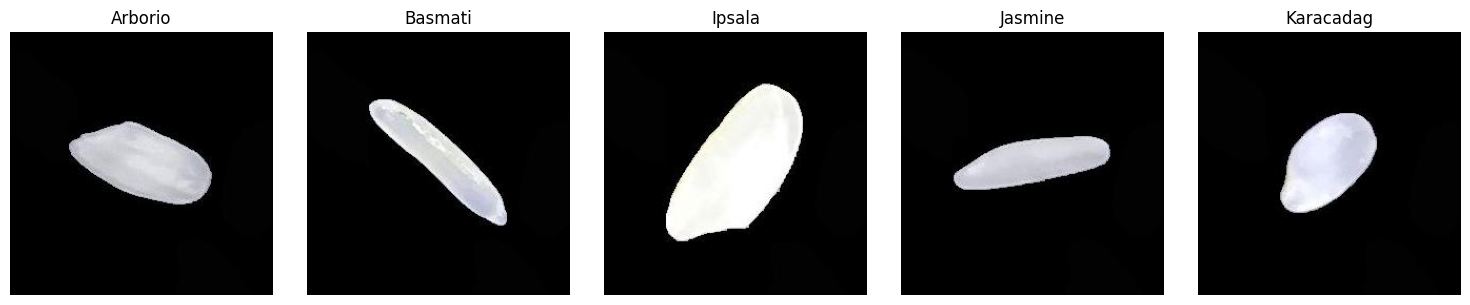

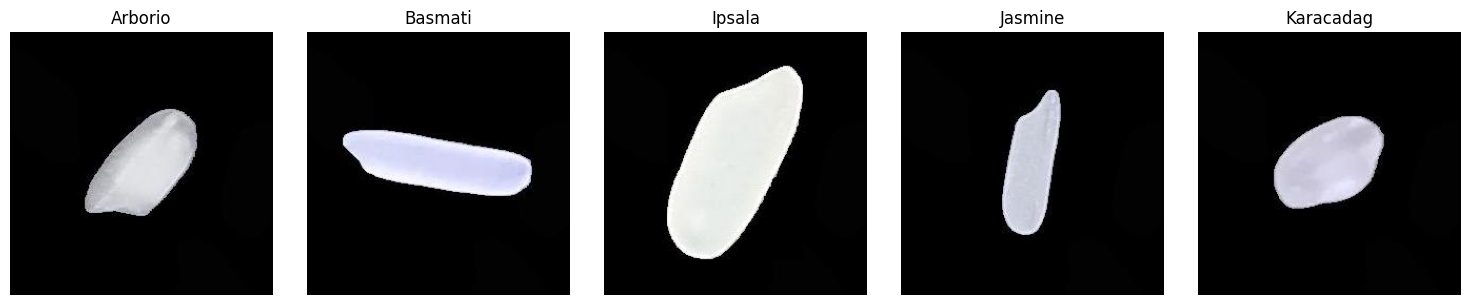

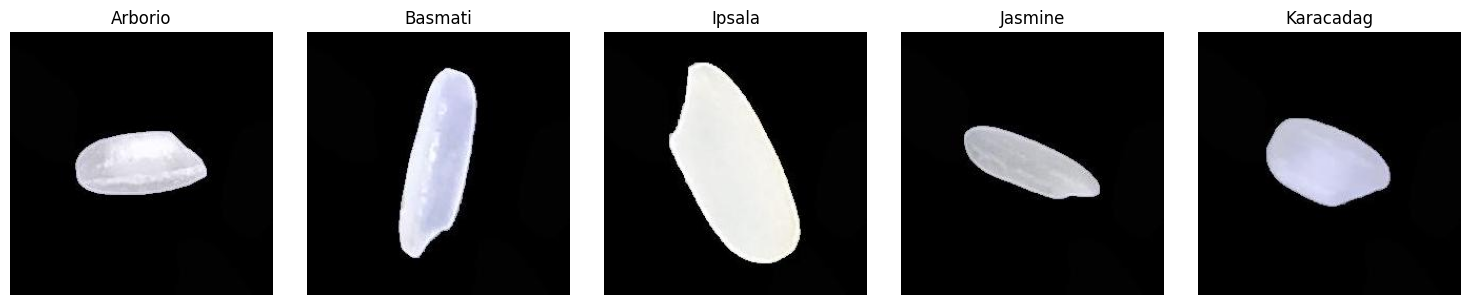

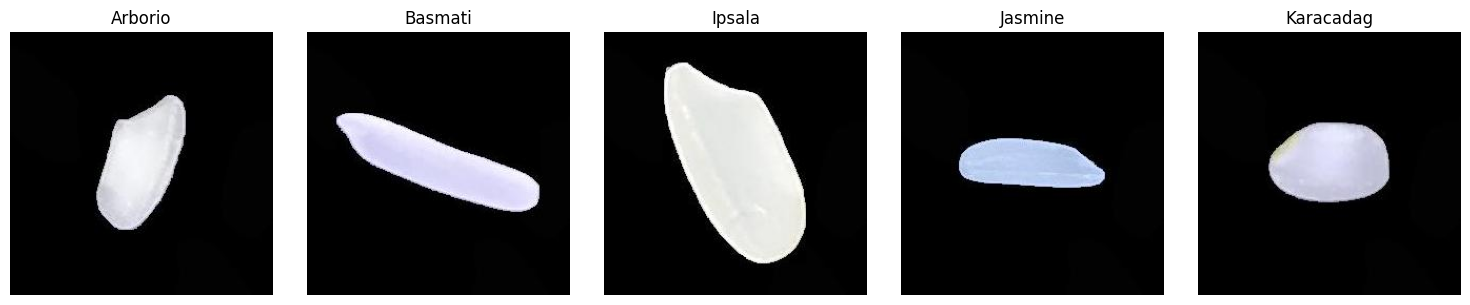

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 15)     │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 15)     │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 30)     │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15870)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,587,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,597,995 (6.10 MB)

 Trainable params: 1,597,605 (6.09 MB)

 Non-trainable params: 390 (1.52 KB)

c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1584/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 307ms/step - accuracy: 0.7095 - loss: 0.7463

KeyboardInterrupt: 

In [14]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# ================================
# 📁 Step 1: Prepare the DataFrame
# ================================
BASE_PATH = r"c:\Users\acer\Downloads\archive\Rice_Image_Dataset"
OUTPUT_CSV = os.path.join(BASE_PATH, "Rice_df.csv")

# ❗ Fix: Only include subdirectories (class folders), ignore .pkl etc.
classes = [f for f in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, f))]
rice_classes = classes[:5]

# 💡 Get image paths
image_paths = list(Path(BASE_PATH).rglob("*.jpg"))
image_names = [img.parent.stem for img in image_paths]
label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_names)

df = pd.DataFrame({
    "link": [str(p) for p in image_paths],
    "name": image_names,
    "label": encoded_labels
})
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ CSV saved to {OUTPUT_CSV}")

# ================================
# 📊 Step 2: Visualize Class Count
# ================================
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="name", palette="Set2")
plt.xticks(rotation=45)
plt.title("Image Count per Rice Class")
plt.tight_layout()
plt.show()

# ================================
# 🖼️ Step 3: Show Sample Images
# ================================
def show_sample_images(path, class_list, rounds=4):
    for _ in range(rounds):
        plt.figure(figsize=(15, 3))
        for i, cls in enumerate(class_list):
            folder = os.path.join(path, cls)
            images = [f for f in os.listdir(folder) if f.endswith(".jpg")]
            if images:
                file = np.random.choice(images)
                img = cv2.imread(os.path.join(folder, file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(1, len(class_list), i + 1)
                plt.imshow(img)
                plt.title(cls)
                plt.axis("off")
        plt.tight_layout()
        plt.show()

show_sample_images(BASE_PATH, rice_classes)

# ================================
# 🧪 Step 4: Data Generators
# ================================
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
datagen = ImageDataGenerator()

train_gen = datagen.flow_from_dataframe(train_df, x_col="link", y_col="name", target_size=(100, 100), class_mode="categorical", seed=42)
val_gen   = datagen.flow_from_dataframe(test_df, x_col="link", y_col="name", target_size=(100, 100), class_mode="categorical", seed=42)

# ================================
# 🧠 Step 5: Build Model
# ================================
model = Sequential([
    Conv2D(15, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(30, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(50, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation="relu"),
    Dropout(0.25),
    Dense(5, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# ================================
# 🚀 Step 6: Train the Model
# ================================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint("model_cnn.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.001, verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

# ================================
# 📉 Step 7: Plot Accuracy & Loss
# ================================
def plot_history(hist):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.grid(); plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend(); plt.grid(); plt.title("Loss")
    plt.tight_layout()
    plt.show()

plot_history(history)

# ================================
# 🧮 Step 8: Evaluate with Confusion Matrix
# ================================
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
conf_matrix = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=list(train_gen.class_indices.keys()),
            yticklabels=list(train_gen.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# ================================
# 📁 Step 1: Prepare the DataFrame
# ================================
BASE_PATH = r"c:\Users\acer\Downloads\archive\Rice_Image_Dataset"
OUTPUT_CSV = os.path.join(BASE_PATH, "Rice_df.csv")

# ❗ Fix: Only include subdirectories (class folders), ignore .pkl etc.
classes = [f for f in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, f))]
rice_classes = classes[:5]

# 💡 Get image paths
image_paths = list(Path(BASE_PATH).rglob("*.jpg"))
image_names = [img.parent.stem for img in image_paths]
label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_names)

df = pd.DataFrame({
    "link": [str(p) for p in image_paths],
    "name": image_names,
    "label": encoded_labels
})
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ CSV saved to {OUTPUT_CSV}")

# ================================
# 📊 Step 2: Visualize Class Count
# ================================
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="name", palette="Set2")
plt.xticks(rotation=45)
plt.title("Image Count per Rice Class")
plt.tight_layout()
plt.show()

# ================================
# 🖼️ Step 3: Show Sample Images
# ================================
def show_sample_images(path, class_list, rounds=4):
    for _ in range(rounds):
        plt.figure(figsize=(15, 3))
        for i, cls in enumerate(class_list):
            folder = os.path.join(path, cls)
            images = [f for f in os.listdir(folder) if f.endswith(".jpg")]
            if images:
                file = np.random.choice(images)
                img = cv2.imread(os.path.join(folder, file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(1, len(class_list), i + 1)
                plt.imshow(img)
                plt.title(cls)
                plt.axis("off")
        plt.tight_layout()
        plt.show()

show_sample_images(BASE_PATH, rice_classes)

# ================================
# 🧪 Step 4: Data Generators
# ================================
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
datagen = ImageDataGenerator()

train_gen = datagen.flow_from_dataframe(train_df, x_col="link", y_col="name", target_size=(100, 100), class_mode="categorical", seed=42)
val_gen   = datagen.flow_from_dataframe(test_df, x_col="link", y_col="name", target_size=(100, 100), class_mode="categorical", seed=42)

# ================================
# 🧠 Step 5: Build Model
# ================================
model = Sequential([
    Conv2D(15, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(30, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(50, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation="relu"),
    Dropout(0.25),
    Dense(5, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# ================================
# 🚀 Step 6: Train the Model
# ================================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint("model_cnn.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.001, verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

# ================================
# 📉 Step 7: Plot Accuracy & Loss
# ================================
def plot_history(hist):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.grid(); plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend(); plt.grid(); plt.title("Loss")
    plt.tight_layout()
    plt.show()

plot_history(history)

# ================================
# 🧮 Step 8: Evaluate with Confusion Matrix
# ================================
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
conf_matrix = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=list(train_gen.class_indices.keys()),
            yticklabels=list(train_gen.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
